# Build linear regression model to predict the score of a submission

## 0. Setup

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime as dt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")
pd.set_option('max_colwidth',100)
pd.set_option('max_columns',20)

## I. load data

In [8]:
Submissions = pd.read_csv("train_test_data_v2.csv", index_col=0)

In [3]:
Submissions.head()

,title_len,body_len,upvote_ratio,time,compound_score,num_early_comments,num_comments,num_top_comments,score
l8rf4k,22,0,0.98,600.0,0.0000,623,12483,68.0,413085.0
l6wu59,38,0,0.97,340.0,0.4019,350,12840,80.0,315560.0
l78uct,29,0,0.97,786.0,0.2732,1332,23681,111.0,280976.0
l846a1,36,0,0.97,784.0,0.2732,1128,20563,106.0,252031.0
l6x130,291,183,0.97,349.0,-0.5267,141,18325,69.0,222152.0


In [9]:
Submissions_df = Submissions.copy()

## II. Data exploration

In [5]:
Submissions_df.describe()

,title_len,body_len,upvote_ratio,time,compound_score,num_early_comments,num_comments,num_top_comments,score
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,73.453901,513.893617,0.912553,666.595745,0.147403,240.588652,4451.134752,135.851064,89279.262411
std,56.902482,2257.866495,0.062763,290.847529,0.487901,490.046121,5423.898220,76.239092,78751.055041
min,4.000000,0.000000,0.570000,54.000000,-0.991400,2.000000,10.000000,5.000000,2.000000
25%,35.000000,0.000000,0.890000,470.000000,0.000000,20.000000,1026.000000,86.000000,12508.000000
50%,56.000000,0.000000,0.930000,673.000000,0.000000,53.000000,2499.000000,114.000000,108236.000000
75%,103.000000,0.000000,0.950000,871.000000,0.510600,129.000000,5912.000000,188.000000,143507.000000
max,300.000000,23250.000000,0.980000,1373.000000,0.999800,2516.000000,28170.000000,433.000000,413085.000000


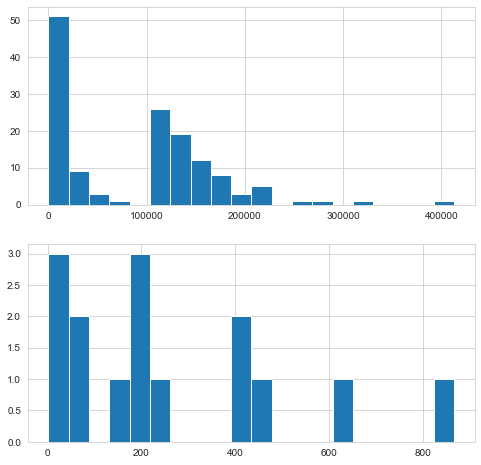

In [6]:
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.hist(Submissions_df.score, bins = 20, density = False)
plt.subplot(2,1,2)
plt.hist(Submissions_df[Submissions_df.score < 1000].score, bins = 20, density = False)


plt.show()

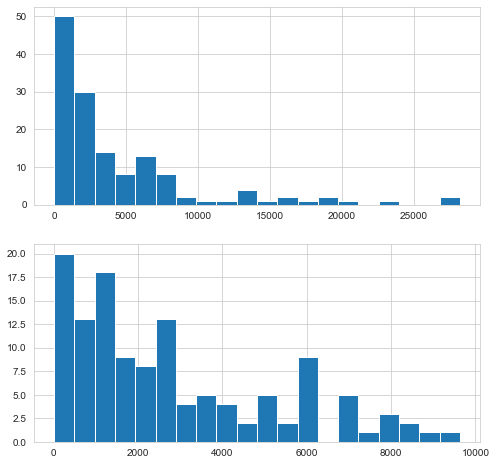

In [7]:
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.hist(Submissions_df.num_comments, bins = 20, density = False)
plt.subplot(2,1,2)
plt.hist(Submissions_df[Submissions_df.num_comments < 10000].num_comments, bins = 20, density = False)


plt.show()

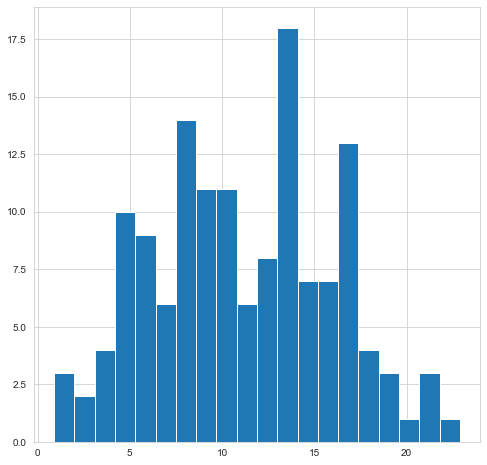

In [4]:
plt.figure(figsize = (8,8))
plt.hist(Submissions_df.time/60, bins = 20, density = False)

plt.show()

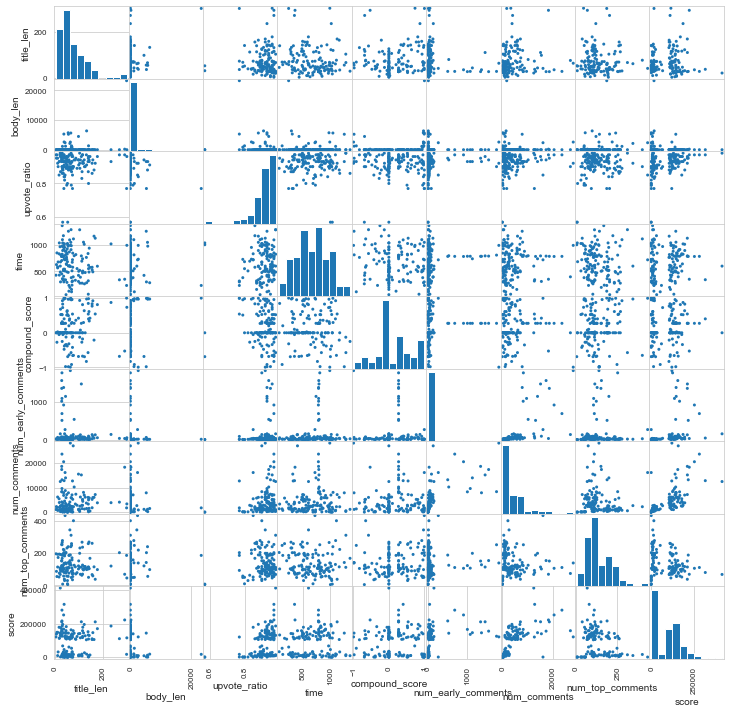

In [10]:
from pandas.plotting import scatter_matrix

scatter_matrix(Submissions_df, figsize = (12,12), alpha = 1)

plt.show()


In [11]:
Submissions_df.corr()['score'].sort_values()

num_top_comments     -0.273454
body_len             -0.180585
compound_score       -0.003053
time                  0.058725
title_len             0.058791
num_early_comments    0.349266
upvote_ratio          0.414965
num_comments          0.642710
score                 1.000000
Name: score, dtype: float64

## III. More data preprocessing

In [11]:
Submissions_df['content_len'] = Submissions_df['title_len']+Submissions_df['body_len']

In [12]:
c1 = Submissions_df['content_len']>500
c2 = Submissions_df['num_early_comments']>200
c3 = Submissions_df['score']>200000
c4 = Submissions_df['num_comments']>10000
outlier = Submissions_df[c1|c2|c3|c4]

In [13]:
Submissions_df=Submissions_df.drop(outlier.index)

## IV. Linear model

In [14]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

### Model 1

In [15]:
features = ['content_len', 'compound_score', 'upvote_ratio','time', 'num_early_comments']

Submissions_train = Submissions_df[features+['score']].sample(frac = .80, random_state = 614)
Submissions_test = Submissions_df[features+['score']].drop(Submissions_train.index)
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler().fit(Submissions_train)
Submissions_train_norm = pd.DataFrame(norm.transform(Submissions_train),columns=Submissions_train.columns, index=Submissions_train.index)
Submissions_test_norm = pd.DataFrame(norm.transform(Submissions_test),columns=Submissions_test.columns, index=Submissions_test.index)
fit = sm.OLS(Submissions_train_norm['score'],sm.add_constant(Submissions_train_norm[features])).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     18.70
Date:                Thu, 27 May 2021   Prob (F-statistic):           6.46e-12
Time:                        17:25:25   Log-Likelihood:                 11.342
No. Observations:                  79   AIC:                            -10.68
Df Residuals:                      73   BIC:                             3.533
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0560      0

### Model 2

In [16]:
features = ['content_len', 'compound_score', 'upvote_ratio','time', 'num_early_comments', 'time2']
Submissions_df['time2'] = Submissions_df['time']**2
Submissions_train = Submissions_df[features+['score']].sample(frac = .80, random_state = 614)
Submissions_test = Submissions_df[features+['score']].drop(Submissions_train.index)
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler().fit(Submissions_train)
Submissions_train_norm = pd.DataFrame(norm.transform(Submissions_train),columns=Submissions_train.columns, index=Submissions_train.index)
Submissions_test_norm = pd.DataFrame(norm.transform(Submissions_test),columns=Submissions_test.columns, index=Submissions_test.index)
fit = sm.OLS(Submissions_train_norm['score'],sm.add_constant(Submissions_train_norm[features])).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     15.89
Date:                Thu, 27 May 2021   Prob (F-statistic):           1.55e-11
Time:                        17:25:25   Log-Likelihood:                 12.088
No. Observations:                  79   AIC:                            -10.18
Df Residuals:                      72   BIC:                             6.410
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1267      0

### Model 3

In [17]:
features = ['content_len', 'compound_score', 'upvote_ratio','time', 'num_early_comments','time2','cs_ratio']
Submissions_df['time2'] = Submissions_df['time']**2
Submissions_df['cs_ratio'] = Submissions_df['upvote_ratio']*Submissions_df['compound_score']
Submissions_train = Submissions_df[features+['score']].sample(frac = .80, random_state = 614)
Submissions_test = Submissions_df[features+['score']].drop(Submissions_train.index)
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler().fit(Submissions_train)
Submissions_train_norm = pd.DataFrame(norm.transform(Submissions_train),columns=Submissions_train.columns, index=Submissions_train.index)
Submissions_test_norm = pd.DataFrame(norm.transform(Submissions_test),columns=Submissions_test.columns, index=Submissions_test.index)
fit = sm.OLS(Submissions_train_norm['score'],sm.add_constant(Submissions_train_norm[features])).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     13.51
Date:                Thu, 27 May 2021   Prob (F-statistic):           5.84e-11
Time:                        17:25:25   Log-Likelihood:                 12.220
No. Observations:                  79   AIC:                            -8.441
Df Residuals:                      71   BIC:                             10.51
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0784      0

### Model 4

In [18]:
features = ['num_early_comments']
Submissions_df['time2'] = Submissions_df['time']**2
Submissions_train = Submissions_df[features+['score']].sample(frac = .80, random_state = 614)
Submissions_test = Submissions_df[features+['score']].drop(Submissions_train.index)
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler().fit(Submissions_train)
Submissions_train_norm = pd.DataFrame(norm.transform(Submissions_train),columns=Submissions_train.columns, index=Submissions_train.index)
Submissions_test_norm = pd.DataFrame(norm.transform(Submissions_test),columns=Submissions_test.columns, index=Submissions_test.index)
fit = sm.OLS(Submissions_train_norm['score'],sm.add_constant(Submissions_train_norm[features])).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     92.42
Date:                Thu, 27 May 2021   Prob (F-statistic):           7.94e-15
Time:                        17:25:25   Log-Likelihood:                 9.9236
No. Observations:                  79   AIC:                            -15.85
Df Residuals:                      77   BIC:                            -11.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0827      0